## Import the Required Data and Libraries

In [1]:
%pip install matplotlib
%pip install pandas
%pip install numpy

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
import os

## Perform Exploratory Data Analysis

In [15]:
DATA_DIRECTORY = "../data/"
RAW_DATA_FILE = f"{DATA_DIRECTORY}/database_raw.csv"

assert os.path.isdir(DATA_DIRECTORY)
assert os.path.isfile(RAW_DATA_FILE)

In [30]:
raw_df = pd.read_csv(RAW_DATA_FILE)

df = raw_df.copy()

df = df[df["Type"] != "Nuclear Explosion"]
df = df[df["Type"] != "Rock Burst"]
df = df[df["Type"] != "Explosion"]

df = df.drop(['Depth Error','Depth Seismic Stations','Magnitude Error', 'Magnitude Seismic Stations','Azimuthal Gap', 'Horizontal Distance', 'Horizontal Error', 'Root Mean Square', 'Location Source', 'Magnitude Source', 'Status', 'ID', 'Source', 'Type'], axis=1)

df = df[~df["Date"].str.endswith("Z")]
df = df[~df["Time"].str.endswith("Z")]

DATA_FILE = f"{DATA_DIRECTORY}/earthquakes.csv"
if not os.path.isfile(DATA_FILE): df.to_csv(DATA_FILE, index=False)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [29]:
dates_df = raw_df.copy()
dates_df["Date"] = pd.to_datetime(dates_df["Date"])
dates_df.sort_values(by="Date", inplace=True)
dates_df.head()

Date      Time  Latitude  Longitude  Depth  Magnitude Magnitude Type
0  01/02/1965  13:44:18    19.246    145.616  131.6        6.0             MW
1  01/04/1965  11:29:49     1.863    127.352   80.0        5.8             MW
2  01/05/1965  18:05:58   -20.579   -173.972   20.0        6.2             MW
3  01/08/1965  18:49:43   -59.076    -23.557   15.0        5.8             MW
4  01/09/1965  13:32:50    11.938    126.427   15.0        5.8             MW

In [20]:
earliest_yr = dates_df.iloc[0, 0].year
latest_yr = dates_df.iloc[-1, 0].year
print(f"The earliest year in the dataset is {earliest_yr}")
print(f"The latest year in the dataset is {latest_yr}")

The earliest year in the dataset is 1965
The latest year in the dataset is 2016


##### Our insight from this visualization is that this dataset contains mostly recent earthquakes, making it more relevant for our problem

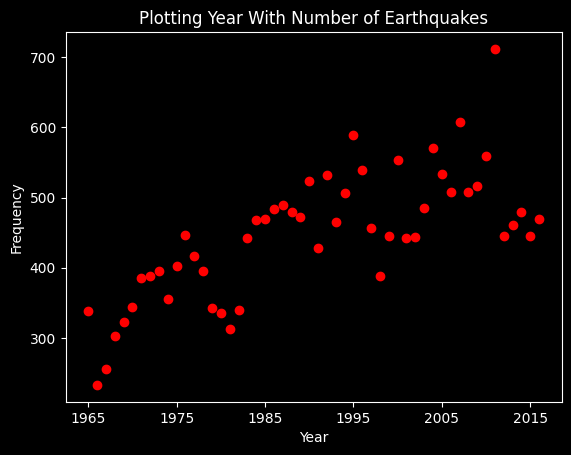

In [37]:
years = [yr for yr in range(1965, 2016+1)]
year_frequencies = [0 for _ in range(len(years))]

for date in dates_df["Date"]:
    yr = date.year
    year_frequencies[yr-1965] += 1

plt.title("Plotting Year With Number of Earthquakes")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.xticks([years[i] for i in range(len(years)) if i % 10 == 0])
plt.scatter(years, year_frequencies, color="red")
plt.show()

#### Explore the different types in this dataset

Our conclusion from this is that there is an insufficient amount of tuples with explosions to make any meaningful analysis. There are precisely 4 such tuples. Therefore, this attribute should be removed.

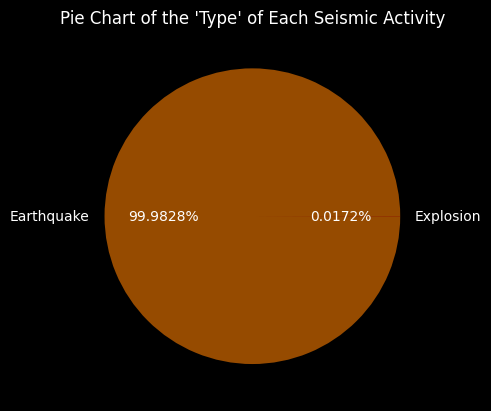

In [84]:
types = list(np.unique(raw_df["Type"].values))
type_frequencies = [0 for _ in range(len(types))]
type_hash = dict()

for i, tp in enumerate(types):
    type_hash[tp] = i

for tp in raw_df["Type"].values:
    type_frequencies[type_hash[tp]] += 1

plt.title("Pie Chart of the 'Type' of Each Seismic Activity")
plt.pie(type_frequencies,
        labels=types,
        autopct='%1.4f%%',
        colors=['#964B00', 'red'])
plt.show()

#### Explore the different magnitude types in this dataset

Our conclusion from this is that there are various types of magnitude types that are represented in sizable proportions, which could be useful for further analysis.

In [94]:
mag_types

['MB', 'MD', 'MH', 'ML', 'MS', 'MW', 'MWB', 'MWC', 'MWR', 'MWW', 'nan']

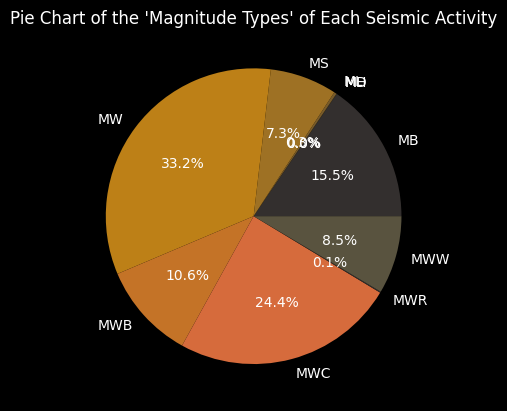

In [115]:
mag_types = list(np.unique(raw_df["Magnitude Type"].dropna().apply(str).values))
mag_type_frequencies = [0 for _ in range(len(mag_types))]
mag_type_hash = dict()

for i, tp in enumerate(mag_types):
    mag_type_hash[tp] = i

for tp in raw_df["Magnitude Type"].values:
    if tp not in mag_types:
        continue
    mag_type_frequencies[mag_type_hash[tp]] += 1

plt.title("Pie Chart of the 'Magnitude Types' of Each Seismic Activity")
plt.pie(mag_type_frequencies,
        labels=mag_types,
        autopct='%1.1f%%',
        colors=["#332F2E", "#59533F", "#473D2C", "#785B2A", "#9E7124", "#BD8017", "#C47327", "#D66B3C"])
plt.show()

## Data Pre-Processing

#### Feature Selection (Removal)
- `Time`: Not terribly relevant for clustering and outlier detection
- `Type`: Too much data imbalance for the classes
- `ID`: Completely irrelevant in earthquake analysis
- `Source`: We are assuming the sources are reliable

#### Feature Creation
- `Country`: The country that this earthquake ("International Waters if not belonging to a country")
- `Ocean`: The ocean that the location sits on (`np.nan` if on land)